# Lecture 11 - Deep Learning (2) - CNN
## Classifying cats and dogs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import shutil

In [2]:
SAMPLES_PER_CLASS = 500  # None
IMG_SIZE = 150  # 224
BATCH_SIZE = 64  # 32
EPOCHS = 10

* Dataset download

In [3]:
import requests
import zipfile
import io

url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

try:
    response = requests.get(url, stream=True, verify=False)
    response.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(os.path.dirname(os.getcwd()))

    path_to_zip = os.path.join(os.path.dirname(os.getcwd()), 'kagglecatsanddogs_5340.zip')

except requests.exceptions.RequestException as e:
    path_to_zip = None

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.microsoft.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [4]:
base_dir = os.path.join(os.path.dirname(path_to_zip), 'PetImages')

cat_dir = os.path.join(base_dir, 'Cat')
dog_dir = os.path.join(base_dir, 'Dog')

In [5]:
from PIL import Image

def remove_corrupted_images(directory):
    removed = 0
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            img = Image.open(filepath)
            img.verify()
        except:
            os.remove(filepath)
            removed += 1
    return removed

cat_removed = remove_corrupted_images(cat_dir)
dog_removed = remove_corrupted_images(dog_dir)

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [6]:
train_dir = '/tmp/cats_dogs_train'
val_dir = '/tmp/cats_dogs_val'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.makedirs(os.path.join(train_dir, 'cats'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'cats'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'dogs'), exist_ok=True)

def split_data(source_dir, train_dest, val_dest, split_ratio=0.8, max_samples=None):
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    if max_samples and len(files) > max_samples:
        np.random.shuffle(files)
        files = files[:max_samples]

    np.random.shuffle(files)

    split_point = int(len(files) * split_ratio)
    train_files = files[:split_point]
    val_files = files[split_point:]

    for f in train_files:
        shutil.copy(os.path.join(source_dir, f), train_dest)

    for f in val_files:
        shutil.copy(os.path.join(source_dir, f), val_dest)

    return len(train_files), len(val_files)

cat_train, cat_val = split_data(cat_dir,
                                 os.path.join(train_dir, 'cats'),
                                 os.path.join(val_dir, 'cats'),
                                 max_samples=SAMPLES_PER_CLASS)

dog_train, dog_val = split_data(dog_dir,
                                 os.path.join(train_dir, 'dogs'),
                                 os.path.join(val_dir, 'dogs'),
                                 max_samples=SAMPLES_PER_CLASS)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


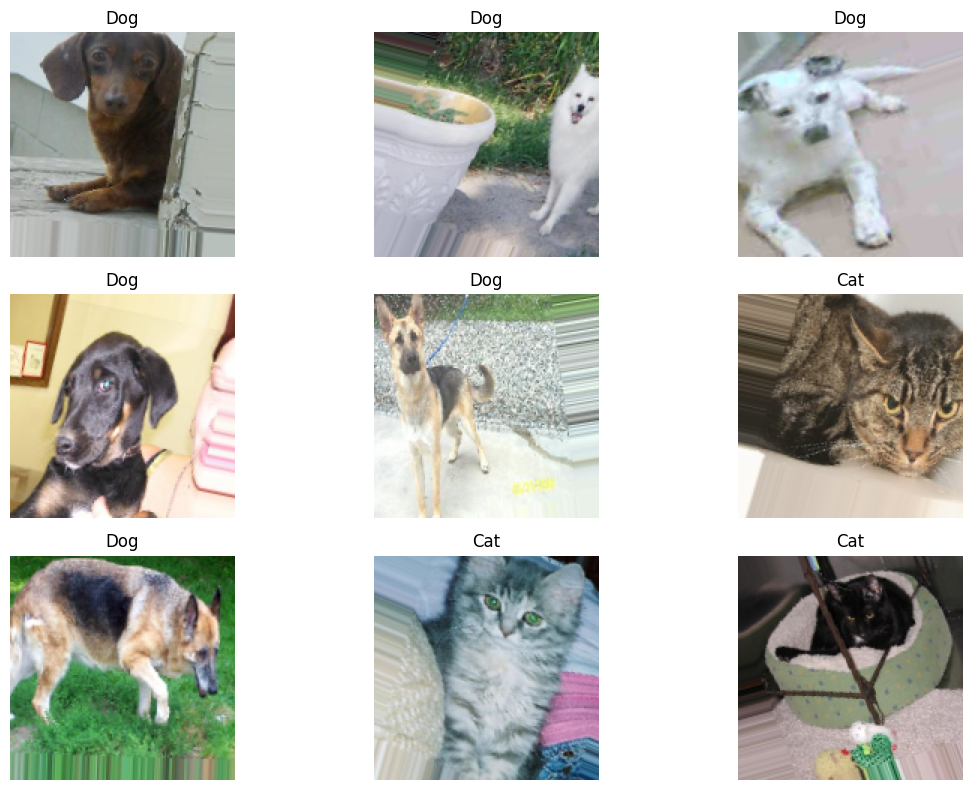

In [8]:
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Building a small Convnet model

In [9]:
model = models.Sequential([
    # First Convolution Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second Convolution Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolution Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolution Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten 및 Dense Layers
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Training

In [11]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 935ms/step - accuracy: 0.5286 - loss: 0.7420 - val_accuracy: 0.5350 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.4813 - loss: 0.6935 - val_accuracy: 0.6100 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step - accuracy: 0.5438 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step - accuracy: 0.5144 - loss: 0.6882 - val_accuracy: 0.5000 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step - accuracy: 0.5084 - loss: 0.6880 - val_accuracy: 0.6100 - val_loss: 0.6579 - learning_rate: 0.0010
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step - accuracy: 0.5474 - loss: 0.6958 - val_accuracy: 0.6300 - val_loss: 0.6779 - learning_rate: 0.0010
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - accuracy: 0.5136 - loss: 0.6890 -

In [13]:
model.save('cats_dogs_classifier.keras')

### Can the model classify cats and dogs well?

In [14]:
loaded_model = model

In [19]:
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()

Saving kmlee.jpg to kmlee.jpg


In [20]:
from tensorflow.keras.preprocessing import image

def predict_uploaded_image(image_bytes, filename):
    img = Image.open(io.BytesIO(image_bytes))

    if img.mode != 'RGB':
        img = img.convert('RGB')

    original_size = img.size

    img_resized = img.resize((IMG_SIZE, IMG_SIZE))

    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = loaded_model.predict(img_array, verbose=0)

    if prediction[0][0] > 0.5:
        predicted_class = 'Dog'
        confidence = prediction[0][0] * 100
    else:
        predicted_class = 'Cat'
        confidence = (1 - prediction[0][0]) * 100

    return img, predicted_class, confidence, original_size

results = []

for filename, image_bytes in uploaded.items():
    try:
        img, pred_class, conf, orig_size = predict_uploaded_image(image_bytes, filename)
        results.append((filename, img, pred_class, conf, orig_size))
        print(f"{filename}: {pred_class} ({conf:.2f}%)")
    except Exception as e:
        print(f"{filename}: Error - {str(e)}")

kmlee.jpg: Cat (50.10%)


## Object detection with YOLO
from: https://docs.ultralytics.com/ko/

In [21]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.6/112.6 GB disk)


In [22]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO('yolo11n.pt')

# Define path to the image file
source = '/content/KakaoTalk_Photo.jpeg'

# Run inference on the source
results = model(source)  # list of Results objects


image 1/1 /content/KakaoTalk_Photo.jpeg: 480x640 1 cup, 3 tvs, 1 mouse, 3 keyboards, 50.6ms
Speed: 11.0ms preprocess, 50.6ms inference, 45.7ms postprocess per image at shape (1, 3, 480, 640)


In [23]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [24]:
from google.colab.patches import cv2_imshow

result_plot = results[0].plot()
cv2_imshow(result_plot)

Output hidden; open in https://colab.research.google.com to view.

## Face emotion recognition

In [25]:
%pip install -q deepface
%pip install -q tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.8 MB/s eta 0:00:00


In [26]:
from deepface import DeepFace
import matplotlib.pyplot as plt
from PIL import Image

26-01-22 12:11:13 - Directory /root/.deepface has been created
26-01-22 12:11:13 - Directory /root/.deepface/weights has been created


Saving kmlee.jpg to kmlee (1).jpg

kmlee (1).jpg:
Emotion: neutral
Probability: {'angry': np.float32(1.4307264), 'disgust': np.float32(2.880662e-09), 'fear': np.float32(0.08728456), 'happy': np.float32(0.0009079296), 'sad': np.float32(2.9551284), 'surprise': np.float32(9.268549e-07), 'neutral': np.float32(95.525955)}


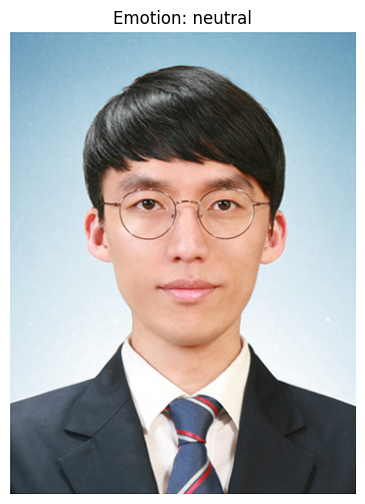

In [28]:
uploaded = files.upload()

for filename, image_bytes in uploaded.items():
     with open(filename, 'wb') as f:
         f.write(image_bytes)

     result = DeepFace.analyze(
         img_path=filename,
         actions=['emotion'],
         enforce_detection=False
     )

     print(f"\n{filename}:")
     print(f"Emotion: {result[0]['dominant_emotion']}")
     print(f"Probability: {result[0]['emotion']}")

     img = Image.open(filename)
     plt.figure(figsize=(8, 6))
     plt.imshow(img)
     plt.title(f"Emotion: {result[0]['dominant_emotion']}")
     plt.axis('off')
     plt.show()